In [1]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from plot import plot_histogram, \
      plot_hist_by_phenotype, plot_triadic_pattern_phenotype, plot_bar_diadic_pattern, \
      plot_xhi_by_phenotype, plot_diadic_pattern, plot_phenotype_combination_per_triangle, \
      plot_phenotype_combination_per_link
from analysis import histogram, measure_global, compute_xhi, compute_xhi_mean, compute_all_xhi_mean
from graph import Network
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from dataset import Dataset, measure_frequency_diadic_pattern, \
      measure_global_frequency_triadic_pattern, \
      measure_triadic_pattern_phenotype_combination, measure_diadic_pattern_combination
import os

import pymc as pm
import arviz as az

In [2]:
file = r"../out/cog_effect_sith/SITH_E3O2P21R12T17_Empty_L10_C500_S50_T0.25_444675.h5"
net = Network()
net.reload_with_hdf5(file)

parameters = net.parameters
inter = parameters["Number of interaction"]
n = parameters["Community size"]
save = False

dirname = "Size_effect_T5/"
if save:
    os.makedirs("../plot/" + dirname + str(n) + "/", exist_ok=True)

In [20]:
t, l = net.get_trust_adjacency_matrix(), net.get_link_adjacency_matrix()
print(f"Number of interaction: ", inter)
print("Asymmetry rate: ", measure_global("Asymmetry", t, l, parameters))
print("Individual asymmetry rate: ", measure_global("Individual asymmetry", t, l, parameters))
print("Out preserving ind. asymmetry: ", measure_global("Individual asymmetry", t, l, parameters, random=True, niter=1000, mode="o"))
print("Saturation rate: ", measure_global("Saturation rate", t, l, parameters))
link_stat = measure_global("Number of link", t, l, parameters)
print("Mean number of link per agent: ", link_stat[0])
print("Standard deviation number of link per agent: ", link_stat[1])
print("Mean number of interaction per link: ", 2 * inter / (n * (n-1)))
tri_pattern_freq = measure_global_frequency_triadic_pattern(l.astype(int), parameters, inter)
dtga = tri_pattern_freq.group_by("Transitive").aggregate("Number")
data = dtga.get_item(True).get_item("Number").get_all_item().values()
transitivity_rate = sum(data) / (n * (n-1) * (n-2) / 6)
print("Transitiviy rate: ", transitivity_rate)

Number of interaction:  444675
Asymmetry rate:  0.5793103448275863
Individual asymmetry rate:  0.26
Out preserving ind. asymmetry:  0.44
Saturation rate:  0.84
Mean number of link per agent:  16.48
Standard deviation number of link per agent:  26.352988445335757
Mean number of interaction per link:  363.0
Transitiviy rate:  0.11785714285714285


In [4]:
local_dt = Dataset("local", inter)
local_dt.init_with_network(net)

### Trust distribution

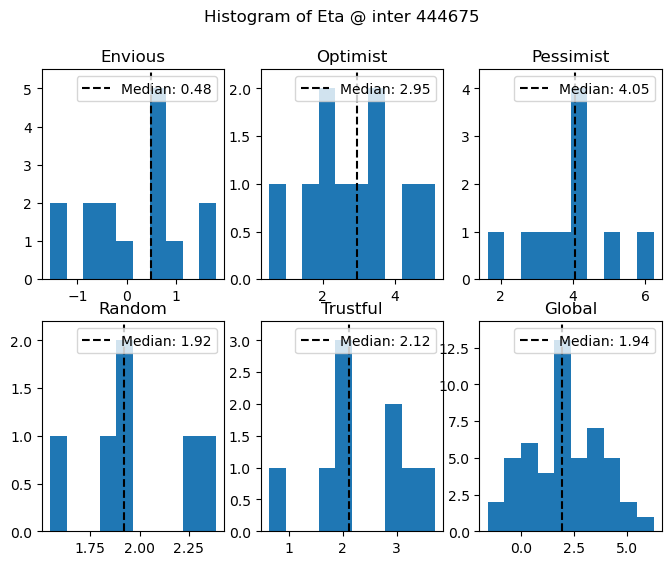

In [5]:
plot_hist_by_phenotype(local_dt, "Eta")
if save:
    plt.savefig("../plot/" + dirname  + str(n) + "/eta_histograms.png")
else:
    plt.show()

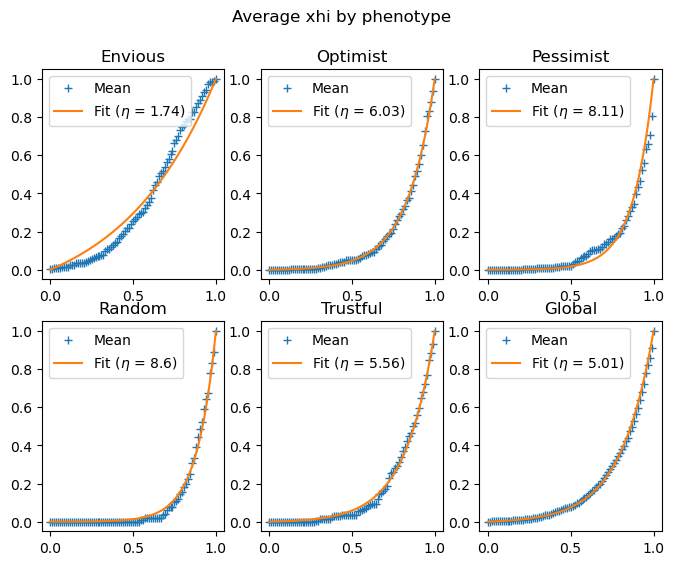

In [6]:
all_xhi = compute_all_xhi_mean(t, parameters)
plot_xhi_by_phenotype(all_xhi)
if save:
    plt.savefig("../plot/" + dirname   + str(n) + "/average_xhi_by_phenotype.png")
else:
    plt.show()

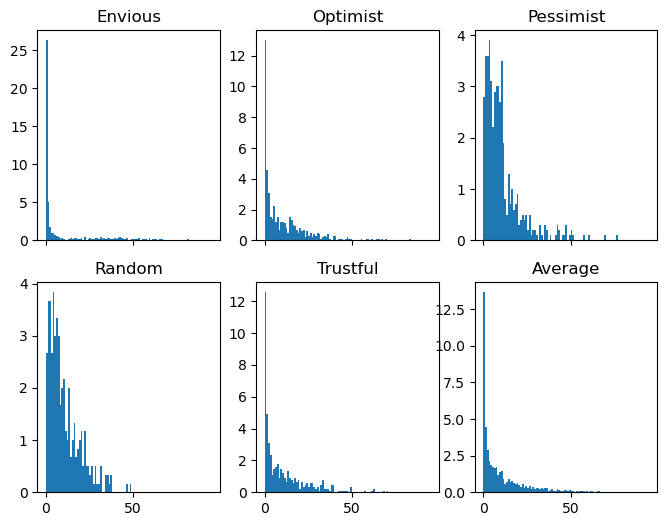

In [7]:
ph_mean = histogram(t, parameters)
fig, ax = plot_histogram(ph_mean, parameters, log=False, color="tab:blue")
plt.show()

### Centrality

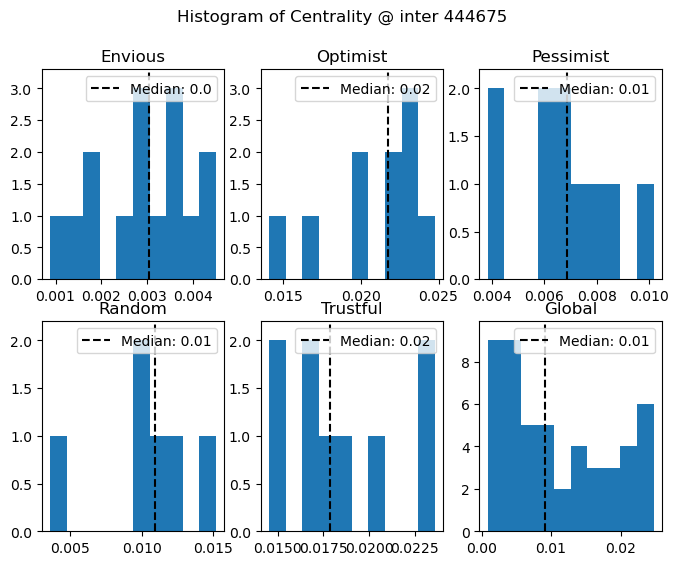

In [8]:
plot_hist_by_phenotype(local_dt, "Centrality")
if save:
    plt.savefig("../plot/" + dirname + str(n) + "/Centrality histograms.png")
else:
    plt.show()

### Diadic pattern

In [9]:
di_pattern_freq = measure_frequency_diadic_pattern(l, net.phenotypes_table, inter)

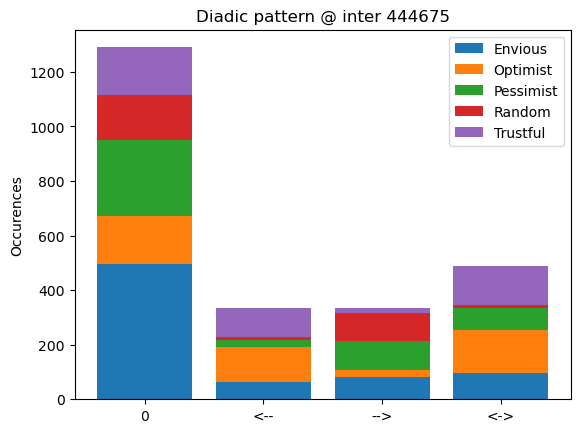

In [10]:
plot_bar_diadic_pattern(di_pattern_freq)
if save:
    plt.savefig("../plot/" + dirname + str(n) + "/diadic_pattern_bar.png")
else:
    plt.show()

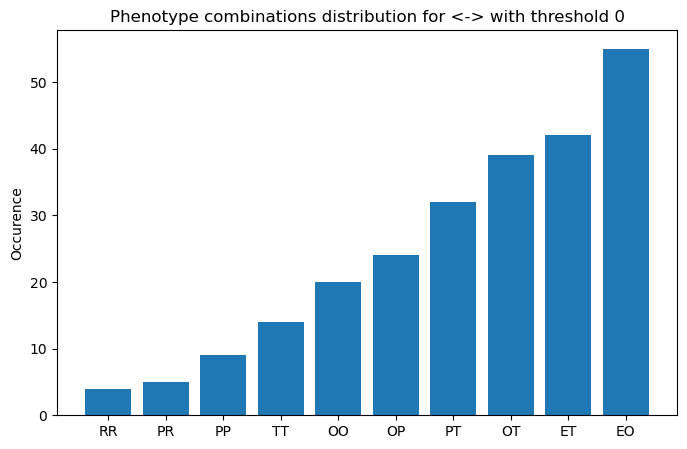

In [11]:
diadic_comb = measure_diadic_pattern_combination(l.astype(int), net.phenotypes_table, inter)
plot_phenotype_combination_per_link('<->', diadic_comb, 0)
plt.show()

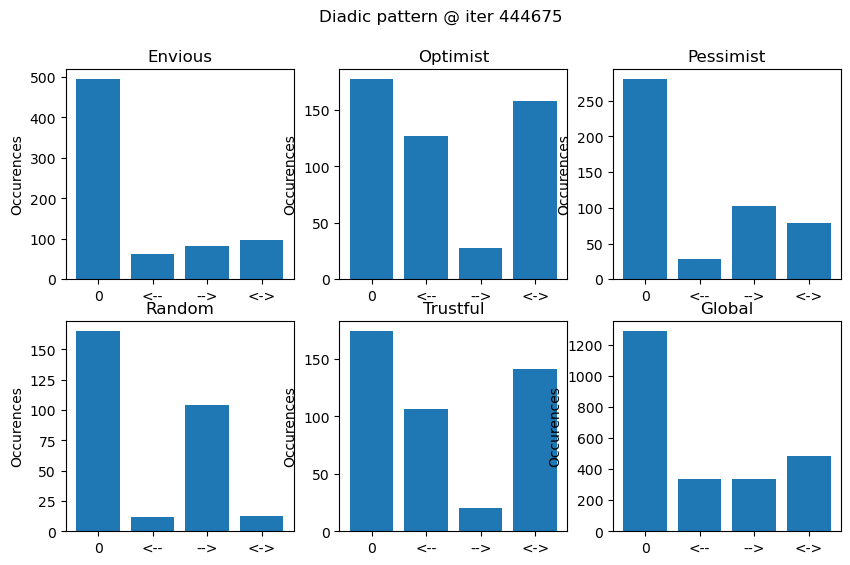

In [12]:
plot_diadic_pattern(di_pattern_freq)
plt.show()

### Triadic pattern

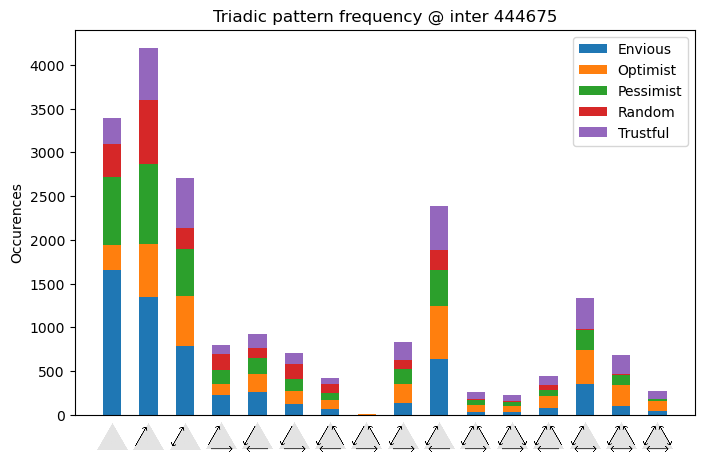

In [14]:
plot_triadic_pattern_phenotype(tri_pattern_freq, parameters)
if save:
    plt.savefig("../plot/" + dirname + str(n) + "/triadic_pattern_bar.png")
else:
    plt.show()

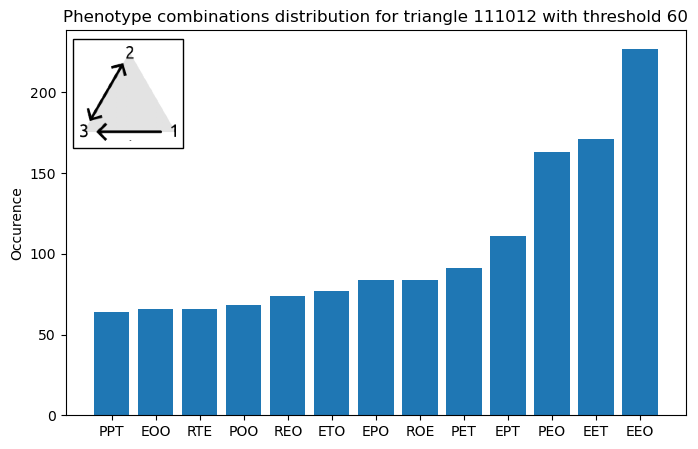

In [17]:
ph_comb_dt = measure_triadic_pattern_phenotype_combination(l.astype(int), parameters, inter)
plot_phenotype_combination_per_triangle("111012", ph_comb_dt, 60)
plt.show()

### Bayesian stuff

Estimated eta:  6.6574840480971105


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_16880\2716832538.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


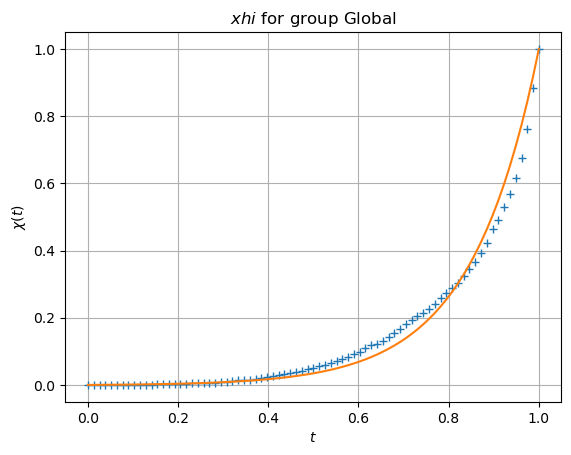

In [ ]:
selector = "Global"
xhi_mean = compute_xhi_mean(t, parameters, ph_selector=selector)
size = xhi_mean.size
t_norm = np.arange(size)/(size-1)
model = lambda i, eta:  (np.exp(eta * i) - 1) / (np.exp(eta) - 1)
popt, copt = curve_fit(model, t_norm, xhi_mean)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi_mean, "+", label="data")
plt.plot(t_norm, model(t_norm, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for group {}".format(selector))
plt.grid()
plt.show()

In [ ]:
xhi_mean = compute_xhi_mean(t, parameters)
size = xhi_mean.size
t_norm = np.arange(size) / (size-1)
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    etas = pm.Normal("etas", mu=2.5, sigma=4)

    # Likelihood
    likelihood = pm.Normal("xhi mean", mu= (np.exp(etas * t_norm) - 1) / (np.exp(etas) - 1), sigma=sigma, observed=xhi_mean)

    # Inference
    idata = pm.sample(3000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [ ]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
etas,9.919,0.083,9.756,10.070,0.001,0.001,12288.0,8707.0,1.0
sigma,0.018,0.001,0.016,0.019,0.000,0.000,12043.0,8707.0,1.0


In [ ]:
pp = pm.sample_posterior_predictive(idata, model, progressbar=False)
idata.extend(pp)

Sampling: [xhi mean]


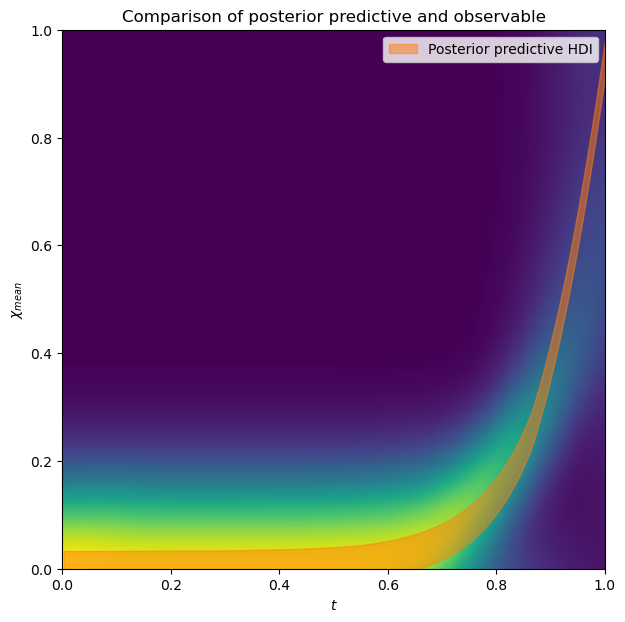

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
az.plot_kde(t_norm, xhi_mean, contour=False, ax=ax, label="Observed data KDE", fill_kwargs={"alpha": 0.1})
az.plot_hdi(t_norm, idata.posterior_predictive["xhi mean"], fill_kwargs={"label": "Posterior predictive HDI"})
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xlabel("$t$")
ax.set_ylabel("$\\chi_{mean}$")
ax.set_title("Comparison of posterior predictive and observable")
plt.legend()
plt.show()